In [1]:
import pandas as pd, numpy as np

In [2]:
import ccxt

In [3]:

ex = ccxt.binance()  # 公開APIだけでOK
ohlcv = ex.fetch_ohlcv('BTC/USDT', timeframe='15m', limit=3000)  # 約1か月

In [4]:
df = pd.DataFrame(ohlcv, columns=['ts','open','high','low','close','vol'])

In [5]:
df['ts'] = pd.to_datetime(df['ts'], unit='ms')

In [6]:
df = df.set_index('ts')

In [7]:
df.tail()

,open,high,low,close,vol
ts,,,,,
2025-09-20 06:00:00,115717.49,115717.50,115625.85,115625.86,43.29340
2025-09-20 06:15:00,115625.86,115690.38,115625.85,115677.66,64.63216
2025-09-20 06:30:00,115677.67,115687.87,115677.66,115677.68,23.55305
2025-09-20 06:45:00,115677.68,115724.34,115677.67,115700.46,28.38746
2025-09-20 07:00:00,115700.47,115722.64,115686.76,115686.76,15.78915


In [8]:
short = df['close'].rolling(20).mean()
long  = df['close'].rolling(60).mean()

# シグナル：短期>長期なら買い、そうでなければノーポジ（売りは最初は無し）
sig = np.where(short>long, 1, 0)

# リターン（対数差分）
ret = np.log(df['close']).diff()

# 将来情報を見ない：シグナルを1本遅らせる
gross = pd.Series(sig, index=df.index).shift(1).fillna(0) * ret

# 取引コスト（片道0.1%を仮置き）
fee = 0.001
turn = pd.Series(sig, index=df.index).diff().abs().fillna(0)  # シグナル変化＝売買
cost = turn.shift(1).fillna(0) * fee

net = (gross - cost).fillna(0)
eq = (1+net).cumprod()

ann_factor = np.sqrt(365*24*4)  # 15分足の雑な年換算
sharpe = (net.mean()/net.std()) * ann_factor
maxdd = (eq/eq.cummax()-1).min()

float(sharpe), float(maxdd), float(eq.iloc[-1])


(-7.255554852984748, -0.06031748867034148, 0.965910121323926)

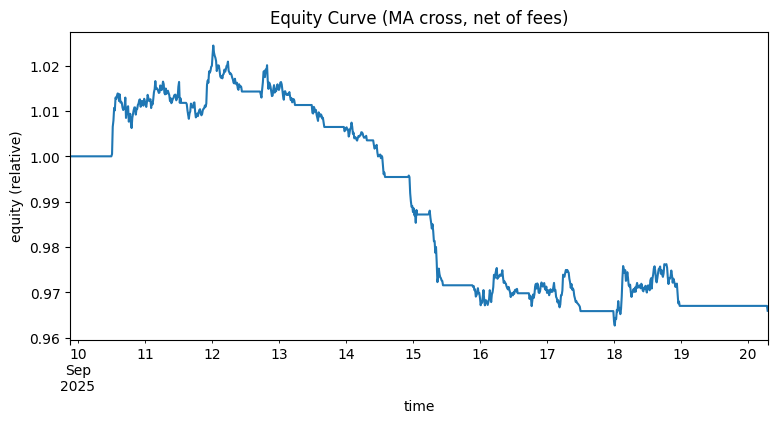

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
eq.plot()
plt.title('Equity Curve (MA cross, net of fees)')
plt.xlabel('time'); plt.ylabel('equity (relative)')
plt.show()
